## Develop Pipeline for monthly processing

For month_nn_, where _nn_=1..72. Steps are:
1. chdir to, creating if necessary, a folder month_nn_ under folder P301\_monthly, which contains the basic config.txt file. 
   
2. run the stage "monthly": this creates the model from the 6-year version, fixing the spectral shape for all the 6-year sources, then runs the stage "addseeds\_pgw".
 * initializes process.Process with the flag fix_spectrum_flag=True. All sources that have TS>5 are saved with a flag fixed_spectrum set, which should prevent the sources from being refit, except for normalization, or moved.

  * need to start update_seeds, but currently need the plots seedcheck.

3. addseeds_pgw will incorporate successful seeds -- this triggers a full iteration cycle ending with "finish_month"

4. run the stage "tables". This makes nside=512 TS and kde tables for the sky. The "check_jobs" process runs a clustering analysis for the part of the sky not masked by the path of the Sun, creating a file seeds_ts.txt. The stage is followed by a "addseeds_ts". This adds the successful seeds from the TS map analysis. also triggers an iteration cycle, ending with "finish_month"



In [39]:
%matplotlib inline
month=6
path=os.path.expandvars('$FERMI/skymodels/P301_monthly/month%02d'%month)
if not os.path.exists(path): 
    os.makedirs(path)
    print 'created %s' %path
os.chdir(path)
from uw.like2 import process; reload(process)
map(reload, (process,));

## Document the relevant stages
A dict in pipeline.stagdict defines behavior

In [1]:
from uw.like2.pipeline import stagedict; reload(stagedict);
stagenames =stagedict.stagenames
t=pd.DataFrame(stagenames)
t['monthly addseeds_pgw  finish_month tables addseeds_ts'.split()].T['next sum help'.split()]

,next,sum,help
monthly,addseeds_pgw,menu config counts,create a monthly model; followed by adding PGW...
addseeds_pgw,update_full,config counts,start update sequence with PGW seeds
finish_month,None,transientinfo,plots for monthly transients
tables,addseeds_ts,hptables,Create tsmap and kde maps
addseeds_ts,update_full,config counts,start update sequence with TS maap seeds


### Test code for creating a new monthly model

In [41]:
r = process.Process('.', fix_spectra_flag=True, quiet=True)

invoking Data.setPhotonBinner for front/back event types...
Failed gti check:
  ltcube: Gti: 462 intervals from 252480000 to 255110000, on time 2192898 
 binfile: Gti: 469 intervals from 252480028 to 255109993, on time 2192653


In [42]:
r.setup_roi(1154)

86 total sources: 0 extended, 3 global


In [43]:
r.process()

2015-08-06 16:34:27 - HP12_1154 - interactive
------------------------------------------------------------------------------------------ 
	 Nearby sources within 5.0 degrees before fit, logL=-4258
name               dist        ra       dec        TS eflux(eV)    index   energy   beta/b
S966-2709           2.3    79.479     5.363        -2       1.1*    2.33     1599     0
P86Y1183            2.4    80.405     1.061         1       2.0*    1.82     5144     0
P86Y1130            2.4    76.738     3.388        -3       2.1*    1.89     4123     0
P86Y1164            2.6    78.963     5.655                 0.8     1.73     6800     0
P86Y1213            2.8    81.875     3.611                 0.7     1.90     1358     2.07 
P86Y1121            3.0    76.400     4.280                 4.6     1.85     4085     0
P86Y1143            3.2    77.358     5.700       -43      41.5!    2.09      954     0
P86Y1118            3.4    76.338     5.002                19.1     2.23      589     0.13 


##Test code for checking the PGWAVE seeds
This is against the current sky model. This ROI was just fit above, adjusting the 6-year spectral normalizations in the ROI. (Adjacent ROI's were not adjusted in this test.)

In [60]:
from uw.like2 import (process,seeds,); map(reload,(process,seeds,))
r = process.Process('.', seed_key='pgw', quiet=True)

invoking Data.setPhotonBinner for front/back event types...
Failed gti check:
  ltcube: Gti: 458 intervals from 255110000 to 257740000, on time 2129642 
 binfile: Gti: 465 intervals from 255110023 to 257739971, on time 2129380


In [61]:
r.setup_roi(840)

71 total sources: 3 extended, 3 global


In [62]:
r.process()

2015-08-04 12:57:21 - HP12_0840 - interactive
added PGW_07_104_06 at SkyDir(270.220,-23.041)
added PGW_07_104_09 at SkyDir(270.192,-23.594)
added PGW_07_104_10 at SkyDir(269.661,-24.458)
added PGW_07_104_14 at SkyDir(268.470,-25.840)
added PGW_07_104_15 at SkyDir(267.199,-27.764)
added PGW_07_072_02 at SkyDir(270.028,-23.510)
added PGW_07_072_03 at SkyDir(269.479,-24.365)
added PGW_07_072_04 at SkyDir(268.645,-25.645)
added PGW_07_088_07 at SkyDir(270.140,-23.507)
added PGW_07_088_10 at SkyDir(269.696,-24.712)
added PGW_07_088_11 at SkyDir(268.627,-25.879)
added PGW_07_088_14 at SkyDir(267.779,-27.164)
added PGW_07_088_17 at SkyDir(269.045,-25.235)
Minimizer warning: bad errors for values ['PGW_07_088_11_Norm']
35 calls, function value, improvement, quality: 6342.0, 18.34, 0.00
Name                  index     value  error(%)  gradient
PGW_07_104_06_Norm        8 7.583e-12      73.2       0.0
PGW_07_104_09_Norm       10 5.573e-12      99.1       0.0
PGW_07_104_10_Norm       12 5.462e-15

In [63]:
r.get_sed?

## Seed finding after stage "tables" 
The "tables" stage triggers a analyze.hptables  run, that executes HPtables.make_seeds(), which in turn runs pipeline.check_ts.make_seeds(). [A little awkward.]
I need to introduce a filter in make_seeds to ignore the path of the Sun for that month.

See [monthly Sun position](monthly Sun position.ipynb), which generated the file \$FERMI/ecliptic\_512.pickle with the ecliptic tuple for each position index in nside=512 (RING as usual). 

Also see the file \$FERMI/skymodels/P301\_monthly/month\_info.csv, which has info for each month.

In [57]:
info = pd.read_csv(open(os.path.expandvars('$FERMI/skymodels/P301_monthly/month_info.csv')),index_col=0)
info.ix[14]

filename    ltcube_014_zmax100.fits
tstart                   2.7352e+08
tstop                    2.7615e+08
sun_ra                      160.867
sun_dec                    8.087439
sun_elon                    159.287
Name: 14, dtype: object

The sun\_ values for for the start of the period. Develop the following function to return a mask. See [Test tables, seed finding](Test tables, seed finding.ipynb)

In [71]:
import pickle
def monthly_ecliptic_mask( month, elat_max=5):
    """return a nside=512 mask for the given month, an integer starting at 1"""
    info = pd.read_csv(open(os.path.expandvars(
                '$FERMI/skymodels/P301_monthly/month_info.csv')),index_col=0)
    ecliptic_info= pickle.load(open(os.path.expandvars('$FERMI/misc/ecliptic_512.pickle')))
    elon_vec = ecliptic_info[:,0]
    elat_mask = np.abs(ecliptic_info[:,1])<5
    elon_min = info.sun_elon[month]
    try:
        elon_max = info.sun_elon[month+1]
    except:
        elon_max = elon_min+30
    if elon_min< elon_max:
        elon_mask = (elon_vec>elon_min) & (elon_vec<elon_max)
    else:
        elon_mask = (elon_vec>elon_min) | (elon_vec<elon_max)
                                        
    return elat_mask & elon_mask
e_mask=monthly_ecliptic_mask(1); sum(e_mask)

20375

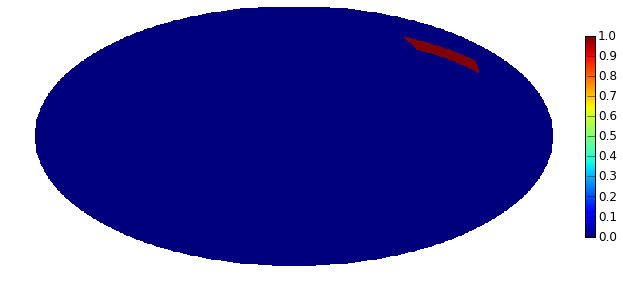

In [72]:
from uw.like2.pub import healpix_map;
mask_check = healpix_map.HParray('mask_check', e_mask)
mask_check.plot()

In [73]:
e_mask=monthly_ecliptic_mask(8); sum(e_mask)

23070

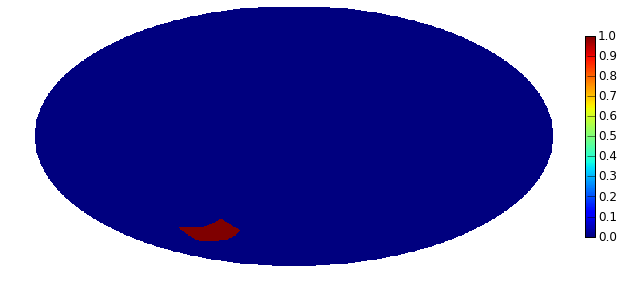

In [74]:
healpix_map.HParray('mask2_check', e_mask).plot()

##Add the TS map seeds

In [3]:
assert os.path.exists('hptables_ts_kde_512.fits')
assert os.path.exists('seeds_ts.txt')

In [5]:
from uw.like2 import process; reload(process)
r = process.Process('.', seed_key='ts' ,quiet=True)

invoking Data.setPhotonBinner for front/back event types...
Failed gti check:
  ltcube: Gti: 458 intervals from 255110000 to 257740000, on time 2129642 
 binfile: Gti: 465 intervals from 255110023 to 257739971, on time 2129380


In [16]:
r.setup_roi(174)

25 total sources: 0 extended, 3 global


In [17]:
r.summarize()

No parameters to fit


In [18]:
from uw.like2 import seeds; reload(seeds)
t =seeds.read_seedfile('ts')
r.process()

2015-08-05 08:30:13 - HP12_0174 - interactive
added Sh07-0037 at SkyDir(194.148,-5.820)
added Sh07-0078 at SkyDir(194.079,-11.718)
added Sh07-1169 at SkyDir(194.147,-5.819)
35 calls, function value, improvement, quality: -3324.3, 3137.17, 0.03
Name                  index     value  error(%)  gradient
Sh07-0037_Norm            0 8.779e-12     254.8       0.7
Sh07-0078_Norm            2 5.275e-13     109.7       0.0
Sh07-1169_Norm            4 8.403e-11      26.9       3.7
TS values
Sh07-0037  14.9  OK
Sh07-0078   3.4  <-- remove
Sh07-1169 3293.2  OK
9 calls, function value, improvement, quality: -3325.8, 0.23, 0.00
Name                  index     value  error(%)  gradient
Sh07-0037_Norm            0 9.269e-12      41.4       0.0
         _Index           1     2.132       9.6      -0.0
  TS = 15.6

check need to repivot sources with TS>10, beta<3.0: 
source                     TS        e0      pivot
processing 1 sources
Sh07-0037                  16      1000       442  will refit
21 c

In [20]:
r.print_summary()

------------------------------------------------------------------------------------------ 
	 Nearby sources within 5.0 degrees HP12_0174
name               dist        ra       dec        TS eflux(eV)    index   energy   beta/b
Sh07-1169           2.7   194.034    -5.784      6303     564.9!    2.18!     394     0
P86Y2971            4.9   197.571   -11.979                 4.2     1.87     3562     0
------------------------------------------------------------------------------------------ 
	Diffuse sources
------------------------------------------------------------------------------------------
ring                        1.00       0.00 
isotrop                     1.00 
SunMoon                     1.00 
------------------------------------------------------------------------------------------


In [10]:
freenames = np.array([ s.name for s  in r.free_sources])
freenames

array(['P86Y1534', 'Sh01-0299', 'PGW_01_047_01'], 
      dtype='|S13')